This file needs requires external data!

(Run on workstation)

In [1]:
import xarray as xr
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean as cmo

import sys

sys.path.append('../src')
import utils as ut
np.set_printoptions(precision=2)

In [2]:
#Get time-independent variables
ds = xr.open_dataset('../data/ecefiles/areas.nc')
area = ds['O1t0.srf'].values;
ds.close()

fnames = sorted(glob.glob(f'../data/ecefiles/n011/n011*.nc'))

ds = xr.open_dataset(fnames[0])
lat = ds['nav_lat'].values
lon = ds['nav_lon'].values
levmid = ds['olevel'].values
lev = ds['olevel_bounds'].values
time_bnds = ds['time_centered_bounds']
thick = ds['e3t'].values #Quasi-time-independent, treated as fixed
ds.close()
secs = (time_bnds[:12,1]-time_bnds[:12,0]).values / np.timedelta64(1, 's')

months = np.arange(0,12)

In [3]:
print(np.argmin((lon[31,:]-(-80))**2))
print(lon[31,207])

print(np.argmin((lat[:,187]-(-70))**2))
print(lat[31,187])

207
-80.49947
31
-70.16064


Can use regular 2D mask for the five regions, use a fixed y1. Make all values outside mask nans, and average along x. (Also for Peninsula)

In [19]:
def get_tracers(runs,x0,x1,y0,y1,t0,t1):
    Tall = {}
    Sall = {}
    
    for run in runs:
        if run=='n011':
            tt0 = t0+100
            tt1 = t1+100
        else:
            tt0 = t0
            tt1 = t1
        fnames = sorted(glob.glob(f'../data/ecefiles/{run}/{run}*.nc'))

        nyears = 0
        for fname in fnames:
            ds = xr.open_dataset(fname)
            nyears += int(np.floor(len(ds.time_counter)/12))
            ds.close()
        assert nyears >= tt1,f'Time series too short, reduce t1'

        T = np.zeros((nyears,len(levmid),y1-y0))
        S = np.zeros((nyears,len(levmid),y1-y0))

        c = -1
        for f,fname in enumerate(fnames):
            if c > tt1:
                #print(year0+y,c,run,'finished')
                break
            ds = xr.open_dataset(fname)
            time = ds['time_centered'].values 

            year0 = int(fname[-27:-23])
            ny = int(len(time)/12)
            if c+ny<tt0:
                c += ny
                #print(year0,c,'skipping file')
                continue

            ds = ds.sel(x=slice(x0,x1),y=slice(y0,y1))
            temp = ds['thetao'].mean(dim='x')
            saln = ds['so'].mean(dim='x')
            lat = ds['nav_lat'].mean(dim='x')
            lon = ds['nav_lon'].mean(dim='x')
            ds.close()

            for y in np.arange(0,ny):
                c += 1
                if c+y<tt0:
                    #print(year0+y,c,'skipping year')
                    continue            
                if c > tt1:
                    #print(year0+y,c,'finished')
                    break
                tb = np.zeros((len(levmid),y1-y0))
                sb = np.zeros((len(levmid),y1-y0))
                for m,mm in enumerate(months):
                    tbb = temp[m+12*y,:,:]
                    sbb = saln[m+12*y,:,:]
                    tb += tbb*secs[m]
                    sb += sbb*secs[m]
                T[c,:,:] = tb/sum(secs)
                S[c,:,:] = sb/sum(secs)
                print(year0+y,c,np.nanmean(T[c,:,:]),np.nanmean(S[c,:,:]))

            Tall[run] = T[tt0:tt1,:,:].mean(axis=0)
            Sall[run] = S[tt0:tt1,:,:].mean(axis=0)
    return Tall,Sall,lat.values

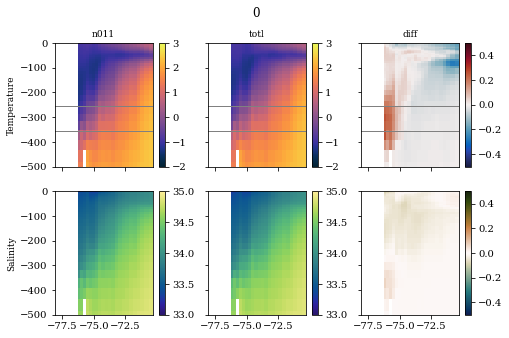

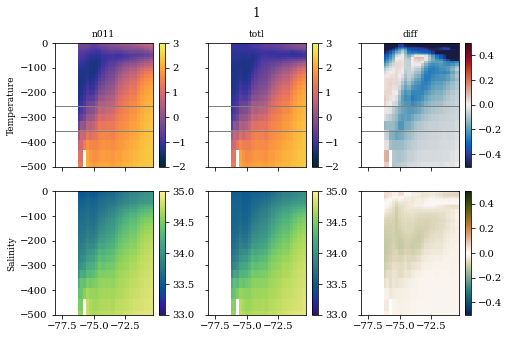

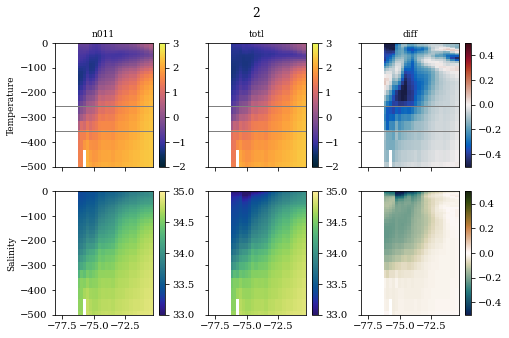

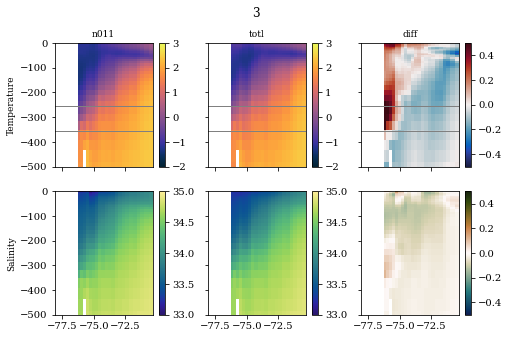

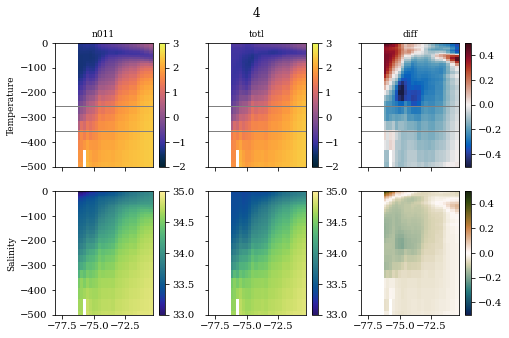

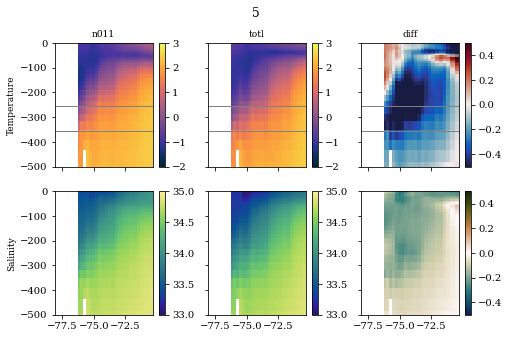

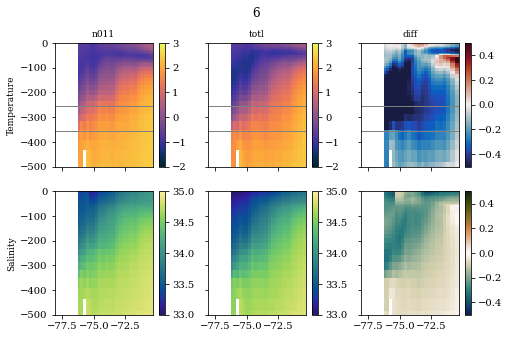

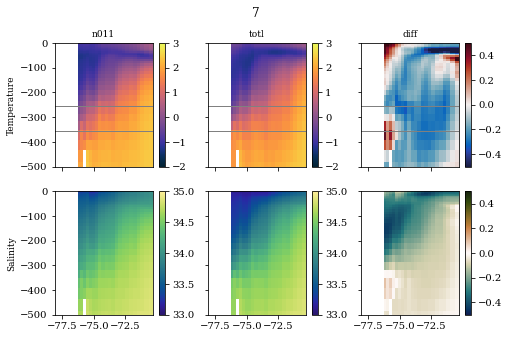

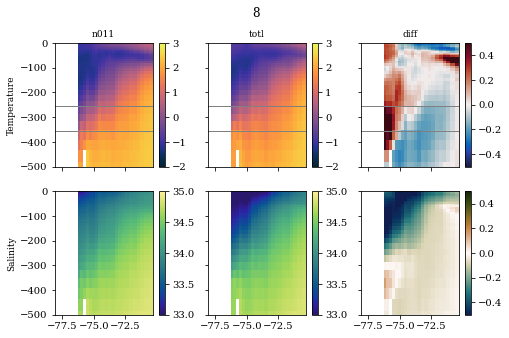

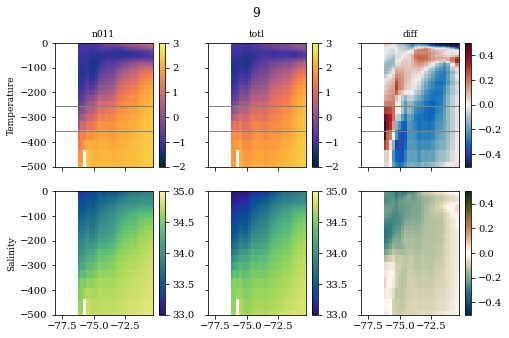

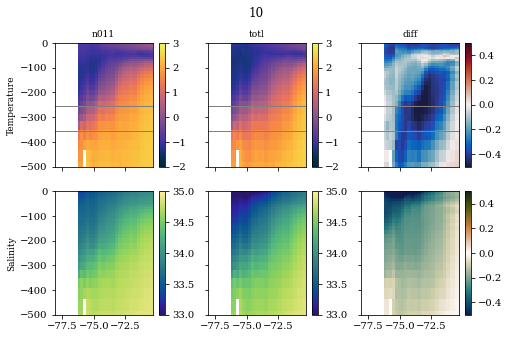

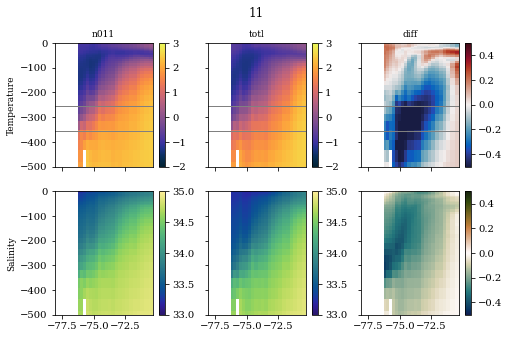

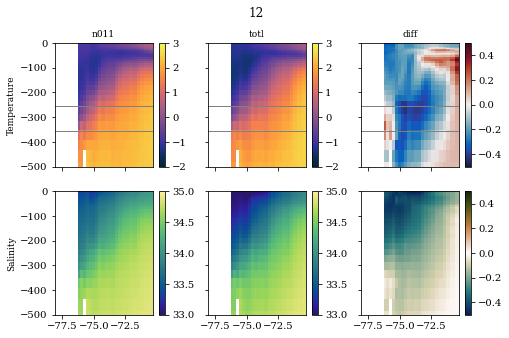

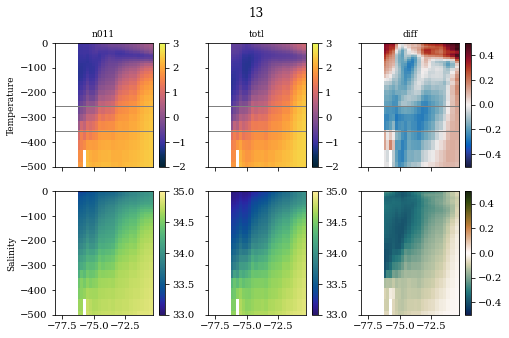

In [17]:
runs = ['n011','totl']
for t0 in range(0,14):
    T,S,lat0 = get_tracers(runs,x0=137,x1=207,y0=0,y1=31,t0=t0,t1=t0+1)

    fig,ax = plt.subplots(2,3,sharex=True,sharey=True)

    zz = -305


    T['diff'] = T[runs[1]]-T[runs[0]]
    S['diff'] = S[runs[1]]-S[runs[0]]

    for v,vv in enumerate(np.append(runs,'diff')):
        if vv=='diff':
            cmap_t = plt.get_cmap('cmo.balance')
            cmap_s = plt.get_cmap('cmo.tarn_r')
            vmin_t = -.5
            vmax_t = .5
            vmin_s = -.5
            vmax_s = .5

        else:
            cmap_t = plt.get_cmap('cmo.thermal')
            cmap_s = plt.get_cmap('cmo.haline')
            vmin_t = -2
            vmax_t = 3
            vmin_s = 33
            vmax_s = 35     

        im = ax[0,v].pcolormesh(lat0,-levmid,T[vv],shading='nearest',cmap=cmap_t,vmin=vmin_t,vmax=vmax_t)
        plt.colorbar(im,ax=ax[0,v])
        im = ax[1,v].pcolormesh(lat0,-levmid,S[vv],shading='nearest',cmap=cmap_s,vmin=vmin_s,vmax=vmax_s)
        plt.colorbar(im,ax=ax[1,v])
        ax[0,v].axhline(zz-50,0,1,c='.5')
        ax[0,v].axhline(zz+50,0,1,c='.5')

        ax[0,v].set_title(vv)

    ax[0,1].set_ylim([-500,0])
    ax[0,0].set_ylabel('Temperature')
    ax[1,0].set_ylabel('Salinity')

    plt.savefig(f'../figures/section_amun_{runs[1]}_{t0:03d}.png',dpi=450)
    fig.suptitle(t0)
    plt.show()

1850 0 0.6360364749687587 34.29698365559737
1851 1 0.5968807589175887 34.3318192778913
1852 2 0.5521664911531379 34.286709359427256
1853 3 0.7050401110697684 34.29290412243351
1854 4 0.6917375356390177 34.25102848016265
1855 5 0.8455953382298735 34.304279458892594
1856 6 0.8031658247430996 34.34373195493252
1857 7 0.7618128660319111 34.33480521149369
1858 8 0.8296719062224749 34.33104985714302
1859 9 0.7397417792332303 34.314717155266635
1860 10 0.6508566749610242 34.312898587599115
1950 100 0.4837646882313939 34.27170591087523
1951 101 0.5765134164049397 34.29003801812809
1952 102 0.5758249147707435 34.28362577288781
1953 103 0.5058885401746436 34.268950357057456
1954 104 0.5262560176947901 34.26158404062933
1955 105 0.6055481386305701 34.29189019996955
1956 106 0.6512664591666163 34.29030790543295
1957 107 0.5546280203964383 34.289199950284335
1958 108 0.5451198371086586 34.28002683267014
1959 109 0.5623787761629576 34.26791025585812
1960 110 0.5582484139057149 34.29668892141562


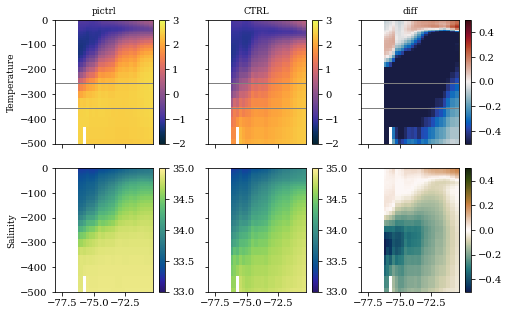

In [22]:
runs = ['n011']

T0,S0,lat0 = get_tracers(runs,x0=137,x1=207,y0=0,y1=31,t0=-100,t1=-90) #Should be piControl
T1,S1,lat0 = get_tracers(runs,x0=137,x1=207,y0=0,y1=31,t0=0,t1=10) #Should be t0=0,t1=150

T = {}
T['pictrl'] = T0['n011']
S['pictrl'] = S0['n011']
T['CTRL']   = T1['n011']
S['CTRL']   = S1['n011']


fig,ax = plt.subplots(2,3,sharex=True,sharey=True)

zz = -305

runs = ['pictrl','CTRL']

T['diff'] = T[runs[1]]-T[runs[0]]
S['diff'] = S[runs[1]]-S[runs[0]]



for v,vv in enumerate(np.append(runs,'diff')):
    if vv=='diff':
        cmap_t = plt.get_cmap('cmo.balance')
        cmap_s = plt.get_cmap('cmo.tarn_r')
        vmin_t = -.5
        vmax_t = .5
        vmin_s = -.5
        vmax_s = .5

    else:
        cmap_t = plt.get_cmap('cmo.thermal')
        cmap_s = plt.get_cmap('cmo.haline')
        vmin_t = -2
        vmax_t = 3
        vmin_s = 33
        vmax_s = 35     

    im = ax[0,v].pcolormesh(lat0,-levmid,T[vv],shading='nearest',cmap=cmap_t,vmin=vmin_t,vmax=vmax_t)
    plt.colorbar(im,ax=ax[0,v])
    im = ax[1,v].pcolormesh(lat0,-levmid,S[vv],shading='nearest',cmap=cmap_s,vmin=vmin_s,vmax=vmax_s)
    plt.colorbar(im,ax=ax[1,v])
    ax[0,v].axhline(zz-50,0,1,c='.5')
    ax[0,v].axhline(zz+50,0,1,c='.5')

    ax[0,v].set_title(vv)

ax[0,1].set_ylim([-500,0])
ax[0,0].set_ylabel('Temperature')
ax[1,0].set_ylabel('Salinity')

plt.savefig(f'../figures/ctrlsection_amun.png',dpi=450)
plt.show()